# **SeamCarve: Content-Aware Image Resizing Using Dynamic Seam Removal**

This notebook explores seam carving, a content-aware image resizing technique. It contains two implementations:

1️⃣ Basic Seam Carving – A straightforward approach for computing energy maps, finding seams, and resizing images.

2️⃣ Optimized Seam Carving – Uses Numba for faster execution and improves performance while maintaining accuracy.

Both implementations demonstrate vertical and horizontal seam carving, visualize seam placement, and produce intelligently resized images while preserving key details. 

Developed by:
- Hager Tamer Abd El-fattah 120210092
- Aya Elsheshtawy Mansoub 120210140
- Noura Moustafa Maklad 120210150

The following code implements seam carving, a technique for resizing images while preserving important content. The process involves:

- Computing an energy map to identify low-importance pixels.
- Using dynamic programming to find and remove the lowest-energy seams.
- Performing both vertical and horizontal resizing for optimal scaling.

This implementation efficiently processes images using NumPy, OpenCV, and Matplotlib, with visualizations to illustrate each step. 

**Test Result:**
- for 720 * 720 images, it took 5 minutes

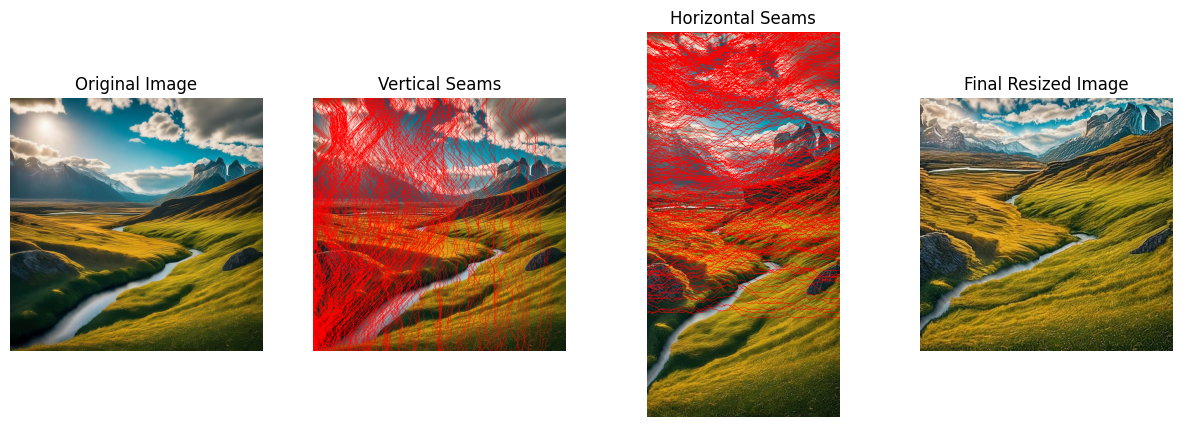

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_energy(img):
    """Computes energy using absolute gradients in x and y directions."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

    dx = np.zeros_like(gray)
    dy = np.zeros_like(gray)

    dx[:, 1:-1] = gray[:, 2:] - gray[:, :-2]
    dy[1:-1, :] = gray[2:, :] - gray[:-2]

    return np.abs(dx) + np.abs(dy)

def find_seam(energy):
    """Finds the optimal vertical seam using dynamic programming."""
    h, w = energy.shape
    M = energy.copy()
    backtrack = np.zeros_like(M, dtype=np.int32)

    for i in range(1, h):
        for j in range(w):
            min_idx = j
            min_energy = M[i-1, j]

            if j > 0 and M[i-1, j-1] < min_energy:
                min_energy = M[i-1, j-1]
                min_idx = j-1
            if j < w-1 and M[i-1, j+1] < min_energy:
                min_energy = M[i-1, j+1]
                min_idx = j+1

            M[i, j] += min_energy
            backtrack[i, j] = min_idx

    seam = np.zeros(h, dtype=np.int32)
    seam[-1] = np.argmin(M[-1])

    for i in range(h-2, -1, -1):
        seam[i] = backtrack[i+1, seam[i+1]]

    return seam

def mark_seam(img, seam):
    """Marks the seam in red for visualization."""
    img_with_seam = img.copy()
    for i in range(len(seam)):
        img_with_seam[i, seam[i]] = [0, 0, 255]
    return img_with_seam

def remove_seam(img, seam):
    """Removes a seam from the image."""
    h, w, c = img.shape
    new_img = np.zeros((h, w-1, c), dtype=np.uint8)
    for i in range(h):
        new_img[i, :, :] = np.delete(img[i, :, :], seam[i], axis=0)
    return new_img

def seam_carving(img, num_seams, direction="vertical"):
    """Performs seam carving with visualization."""
    seam_visual = img.copy()

    if direction == "vertical":
        for _ in range(num_seams):
            energy = compute_energy(img)
            seam = find_seam(energy)
            seam_visual = mark_seam(seam_visual, seam)
            img = remove_seam(img, seam)
    elif direction == "horizontal":
        img = np.transpose(img, (1, 0, 2))
        seam_visual = np.transpose(seam_visual, (1, 0, 2))

        for _ in range(num_seams):
            energy = compute_energy(img)
            seam = find_seam(energy)
            seam_visual = mark_seam(seam_visual, seam)
            img = remove_seam(img, seam)

        img = np.transpose(img, (1, 0, 2))
        seam_visual = np.transpose(seam_visual, (1, 0, 2))

    return img, seam_visual

def seam_carving_combined(image_path, scale=0.5):
    """Performs vertical and horizontal seam carving in one process."""
    img = cv2.imread(image_path)
    if img is None:
        print("Error loading image.")
        return

    h, w = img.shape[:2]
    target_width = int(w * scale)
    target_height = int(h * scale)

    num_seams_v = w - target_width
    num_seams_h = h - target_height

    img_v, seam_visual_v = seam_carving(img, num_seams_v, "vertical")
    img_final, seam_visual_h = seam_carving(img_v, num_seams_h, "horizontal")

    cv2.imwrite("resized_combined.jpg", img_final)
    cv2.imwrite("seams_visualization_combined.jpg", seam_visual_v)

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(seam_visual_v, cv2.COLOR_BGR2RGB))
    plt.title("Vertical Seams")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(seam_visual_h, cv2.COLOR_BGR2RGB))
    plt.title("Horizontal Seams")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
    plt.title("Final Resized Image")
    plt.axis("off")

    plt.show()

# Example usage:
image_path = "/content/img.jpg"
seam_carving_combined(image_path, scale=0.5)


**Optimized Seam Carving for Image Resizing**

The following code demonstrates seam carving, an advanced content-aware image resizing technique. Key features include:

- Energy Map Calculation – Identifies low-importance pixels.
- Optimized Seam Detection & Removal – Uses Numba for fast processing.
- Dual-Axis Seam Carving – Removes vertical and horizontal seams for efficient resizing.
- Visualization – Displays original, seam-marked, and final resized images.

The approach ensures minimal distortion while resizing images intelligently. 

**Test Results:**
- for 720 * 720 image, it took 11 seconds.

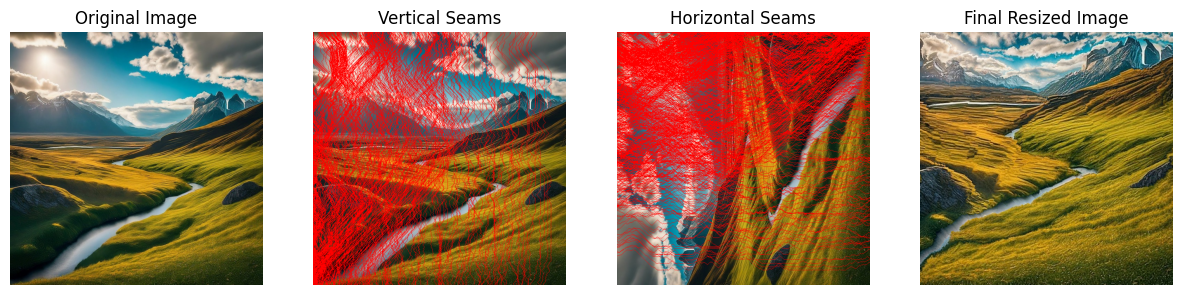

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from numba import njit
from PIL import Image

# Load the uploaded image
image_path = "/content/img.jpg"

# Check if file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at {image_path}")

# Load image using OpenCV
img = cv2.imread(image_path)

# Check if the image was loaded correctly
if img is None:
    print("OpenCV failed to load the image, trying PIL...")
    img_pil = Image.open(image_path)
    img = np.array(img_pil)  # Convert PIL image to NumPy array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to OpenCV format

# Function to compute energy of the image
def compute_energy(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
    dx = np.zeros_like(gray)
    dy = np.zeros_like(gray)

    dx[:, 1:-1] = gray[:, 2:] - gray[:, :-2]
    dy[1:-1, :] = gray[2:, :] - gray[:-2]

    return np.abs(dx) + np.abs(dy)

# Optimized function to find the optimal seam
@njit
def find_seam(energy):
    h, w = energy.shape
    M = energy.copy()
    backtrack = np.zeros_like(M, dtype=np.int32)

    for i in range(1, h):
        for j in range(w):
            min_energy = M[i-1, j]
            min_idx = j

            if j > 0 and M[i-1, j-1] < min_energy:
                min_energy = M[i-1, j-1]
                min_idx = j-1
            if j < w-1 and M[i-1, j+1] < min_energy:
                min_energy = M[i-1, j+1]
                min_idx = j+1

            M[i, j] += min_energy
            backtrack[i, j] = min_idx

    seam = np.zeros(h, dtype=np.int32)
    seam[-1] = np.argmin(M[-1])

    for i in range(h-2, -1, -1):
        seam[i] = backtrack[i+1, seam[i+1]]

    return seam

# Optimized function to remove the seam from the image
@njit
def remove_seam(img, seam):
    h, w, c = img.shape
    new_img = np.zeros((h, w-1, c), dtype=np.uint8)

    for i in range(h):
        for j in range(seam[i]):
            new_img[i, j] = img[i, j]
        for j in range(seam[i], w-1):
            new_img[i, j] = img[i, j+1]

    return new_img

# Function to mark seam on image for visualization
def mark_seam(img, seam):
    img_with_seam = img.copy()
    for i in range(len(seam)):
        img_with_seam[i, seam[i]] = [0, 0, 255]  # Red seam
    return img_with_seam

# Function to perform seam carving
def seam_carving(img, num_seams_v, num_seams_h):
    vertical_seam_img = img.copy()

    for _ in range(num_seams_v):
        energy = compute_energy(img)
        seam = find_seam(energy)
        vertical_seam_img = mark_seam(vertical_seam_img, seam)
        img = remove_seam(img, seam)

    img = np.transpose(img, (1, 0, 2))
    horizontal_seam_img = vertical_seam_img.copy()

    for _ in range(num_seams_h):
        energy = compute_energy(img)
        seam = find_seam(energy)
        horizontal_seam_img = mark_seam(horizontal_seam_img, seam)
        img = remove_seam(img, seam)

    img = np.transpose(img, (1, 0, 2))
    horizontal_seam_img = np.transpose(horizontal_seam_img, (1, 0, 2))

    return img, vertical_seam_img, horizontal_seam_img

# Perform seam carving
h, w = img.shape[:2]
target_width = w // 2
target_height = h // 2

num_seams_v = w - target_width
num_seams_h = h - target_height

resized_img, vertical_seam_img, horizontal_seam_img = seam_carving(img, num_seams_v, num_seams_h)

# Plot and display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(vertical_seam_img, cv2.COLOR_BGR2RGB))
plt.title("Vertical Seams")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(horizontal_seam_img, cv2.COLOR_BGR2RGB))
plt.title("Horizontal Seams")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title("Final Resized Image")
plt.axis("off")

plt.show()
